# Example 1: Function Fitting

In this example, we will cover how to leverage grid refinement to maximimze KANs' ability to fit functions

intialize model and create dataset

In [23]:
import sys
import os

# Find parent directory and add to path
parent_dir = os.pardir
sys.path.append(parent_dir)

from kan import *
from kan import utils

# initialize KAN with G=3
model = KAN(width=[2,1,1], grid=3, k=3)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = utils.create_dataset(f, n_var=2)

Directory created: ./model


Train KAN (grid=3)

In [24]:
model.train(dataset, opt="LBFGS", steps=20);

train loss: 6.29e-01 | test loss: 6.52e-01 | reg: 4.23e+00 : 100%|██| 20/20 [00:04<00:00,  4.05it/s]


The loss plateaus. we want a more fine-grained KAN!

In [26]:
# initialize a more fine-grained KAN with G=10
model2 = KAN(width=[2,1,1], grid=10, k=3)
# initialize model2 from model
model2.initialize_from_another_model(model, dataset['train_input']);

Directory already exists: ./model


Train KAN (grid=10)

In [27]:
model2.train(dataset, opt="LBFGS", steps=20);

train loss: 5.58e-01 | test loss: 5.88e-01 | reg: 4.42e+00 : 100%|██| 20/20 [00:05<00:00,  3.70it/s]


The loss becomes lower. This is good! Now we can even iteratively making grids finer.

In [28]:
grids = np.array([5,10,20,50,100])

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k)
    if i != 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

Directory already exists: ./model


train loss: 6.09e-03 | test loss: 6.25e-03 | reg: 6.15e+00 : 100%|██| 50/50 [00:09<00:00,  5.39it/s]


Directory already exists: ./model


train loss: 2.75e-04 | test loss: 3.14e-04 | reg: 6.16e+00 : 100%|██| 50/50 [00:08<00:00,  6.16it/s]


Directory already exists: ./model


train loss: 2.50e-05 | test loss: 4.71e-05 | reg: 6.16e+00 : 100%|██| 50/50 [00:08<00:00,  5.91it/s]


Directory already exists: ./model


train loss: 3.82e-06 | test loss: 1.68e-05 | reg: 6.16e+00 : 100%|██| 50/50 [00:06<00:00,  7.81it/s]


Directory already exists: ./model


train loss: 2.54e-06 | test loss: 1.55e-05 | reg: 6.16e+00 : 100%|██| 50/50 [00:04<00:00, 12.00it/s]


Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

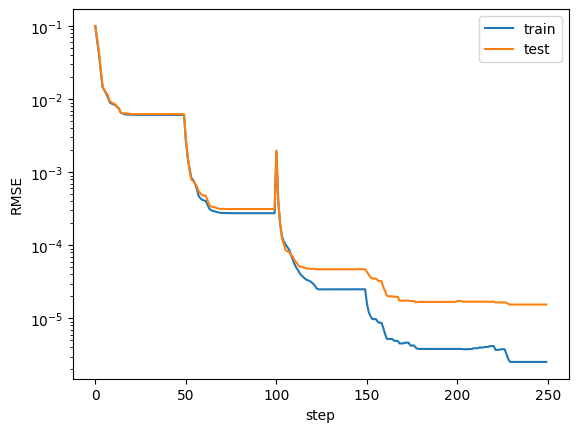

In [29]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Neural scaling laws

Text(0, 0.5, 'RMSE')

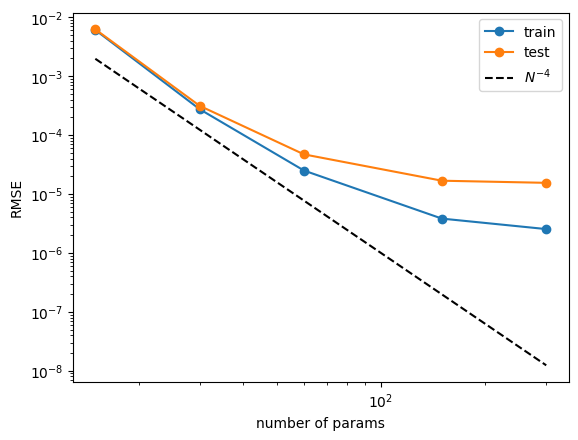

In [30]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')